In [1]:
# imports

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend

In [2]:
# download and prepare data
!gdown 1j6GMx33DCcbUOS8J3NHZ-BMHgk7H-oC_
!unzip -q data.zip
%cd data
!ls

Downloading...
From (original): https://drive.google.com/uc?id=1j6GMx33DCcbUOS8J3NHZ-BMHgk7H-oC_
From (redirected): https://drive.google.com/uc?id=1j6GMx33DCcbUOS8J3NHZ-BMHgk7H-oC_&confirm=t&uuid=1c355b65-2439-4a12-b1da-ab9058a7eb71
To: /content/data.zip
100% 1.39G/1.39G [00:43<00:00, 32.1MB/s]
/content/data
BIWI_noTrack.npz  BIWI_train.npz  TYY_create_db_biwi_70_30.py
BIWI_test.npz	  type1		  TYY_create_db_biwi.py


In [3]:
# load training data.
# for more info, read how the pose datasets are commonly loaded in the recent papaers.

path = 'type1'
dataset_list = []
labels_list = []
for dataset in os.listdir(path):
  if dataset.endswith('.npz') and dataset != 'AFLW2000.npz':
    full_path = os.path.join(path, dataset)
    loaded_data = np.load(full_path)
    pose = loaded_data['pose']
    images = loaded_data['image']

    # trim the dataset.
    pose_trimmed = []
    images_trimmed = []

    # check for invalid poses.
    for i, _ in enumerate(pose):
      if np.max(pose[i])<=99.0 and np.min(pose[i])>=-99.0:
        images_trimmed.append(images[i])
        pose_trimmed.append(pose[i])
      else:
        pass

    # replace the main set.
    images = np.array(images_trimmed)
    pose = np.array(pose_trimmed)
    del pose_trimmed, images_trimmed

    dataset_list.append(images)
    labels_list.append(pose)

X_train = np.concatenate([dataset for dataset in dataset_list], axis=0)
Y_train = np.concatenate([label for label in labels_list], axis=0)

print(X_train.shape)
print(Y_train.shape)

del path, dataset_list, labels_list, dataset, full_path, loaded_data
del pose, images

(122415, 64, 64, 3)
(122415, 3)


In [ ]:
# load benchmark datasets.

# Testing: AFLW2000.npz or BIWI_noTrack.npz
biwi_no_track = np.load('BIWI_noTrack.npz')
# 64
image_size = biwi_no_track['img_size']

pose_1 = biwi_no_track['pose']
images_1 = biwi_no_track['image']


# trim the dataset.
pose_trimmed = []
images_trimmed = []

# check for invalid poses.
for i, _ in enumerate(pose_1):
  if np.max(pose_1[i])<=99.0 and np.min(pose_1[i])>=-99.0:
    images_trimmed.append(images_1[i])
    pose_trimmed.append(pose_1[i])
  else:
    pass

# replace the main set.
images_1 = np.array(images_trimmed)
pose_1 = np.array(pose_trimmed)
del pose_trimmed, images_trimmed
print(pose_1.shape)
print(images_1.shape)


aflw2000 = np.load('type1/AFLW2000.npz')
# 64
image_size = aflw2000['img_size']

pose_2 = aflw2000['pose']
images_2 = aflw2000['image']

# trim the dataset.
pose_trimmed = []
images_trimmed = []

# check for invalid poses.
for i, _ in enumerate(pose_2):
  if np.max(pose_2[i])<=99.0 and np.min(pose_2[i])>=-99.0:
    images_trimmed.append(images_2[i])
    pose_trimmed.append(pose_2[i])
  else:
    pass

# replace the main set.
images_2 = np.array(images_trimmed)
pose_2 = np.array(pose_trimmed)
del pose_trimmed, images_trimmed
print(pose_2.shape)
print(images_2.shape)
# merge them and delete the rest.

# X_test = np.concatenate((images_1, images_2), axis=0)
# Y_test = np.concatenate((pose_1, pose_2), axis=0)

# print(X_test.shape)
# print(Y_test.shape)

X_test_1 = images_1
Y_test_1 = pose_1
X_test_2 = images_2
Y_test_2 = pose_2

del biwi_no_track, image_size, pose_1, pose_2, images_1, images_2

(13219, 3)
(13219, 64, 64, 3)
(1969, 3)
(1969, 64, 64, 3)


In [ ]:
# lets take a look at label metrics.

yaw, pitch, roll = Y_train[:, 0], Y_train[:, 1], Y_train[:, 2]

print(yaw.min(), yaw.max(), yaw.mean(), yaw.std())
print(pitch.min(), pitch.max(), pitch.mean(), pitch.std())
print(roll.min(), roll.max(), roll.mean(), roll.std())

-89.9985818251308 89.9954604286801 0.0018387899282735394 54.82301429912778
-98.09495829366969 96.52713618101745 -8.849265980565095 12.466646499981618
-97.37726933644143 97.11325520426375 0.04085814609804002 11.794368085285697


In [ ]:
# augmentation and learningratedecay functions for further training the model.
# borrowed from https://github.com/shamangary/FSA-Net

from tensorflow import keras
import numpy as np
import sys
import tensorflow as tf
import cv2
from tensorflow.keras import backend as K


def random_crop(x,dn):
    dx = np.random.randint(dn,size=1)[0]
    dy = np.random.randint(dn,size=1)[0]
    h = x.shape[0]
    w = x.shape[1]
    out = x[0+dy:h-(dn-dy),0+dx:w-(dn-dx),:]
    out = cv2.resize(out, (h,w), interpolation=cv2.INTER_CUBIC)
    return out

def random_crop_black(x,dn):
    dx = np.random.randint(dn,size=1)[0]
    dy = np.random.randint(dn,size=1)[0]

    h = x.shape[0]
    w = x.shape[1]

    dx_shift = np.random.randint(dn,size=1)[0]
    dy_shift = np.random.randint(dn,size=1)[0]
    out = x*0
    out[0+dy_shift:h-(dn-dy_shift),0+dx_shift:w-(dn-dx_shift),:] = x[0+dy:h-(dn-dy),0+dx:w-(dn-dx),:]

    return out

def random_crop_white(x,dn):
    dx = np.random.randint(dn,size=1)[0]
    dy = np.random.randint(dn,size=1)[0]
    h = x.shape[0]
    w = x.shape[1]

    dx_shift = np.random.randint(dn,size=1)[0]
    dy_shift = np.random.randint(dn,size=1)[0]
    out = x*0+255
    out[0+dy_shift:h-(dn-dy_shift),0+dx_shift:w-(dn-dx_shift),:] = x[0+dy:h-(dn-dy),0+dx:w-(dn-dx),:]

    return out

def augment_data(images):
    for i in range(0,images.shape[0]):

        rand_r = np.random.random()
        if  rand_r < 0.25:
            dn = np.random.randint(15,size=1)[0]+1
            images[i] = random_crop(images[i],dn)

        elif rand_r >= 0.25 and rand_r < 0.5:
            dn = np.random.randint(15,size=1)[0]+1
            images[i] = random_crop_black(images[i],dn)

        elif rand_r >= 0.5 and rand_r < 0.75:
            dn = np.random.randint(15,size=1)[0]+1
            images[i] = random_crop_white(images[i],dn)


        if np.random.random() > 0.3:
            images[i] = tf.keras.preprocessing.image.random_zoom(images[i], [0.8,1.2], row_axis=0, col_axis=1, channel_axis=2)

    return images


def data_generator_reg(X,Y,batch_size):

    while True:
        idxs = np.random.permutation(len(X))
        X = X[idxs]
        Y = Y[idxs]
        p,q = [],[]
        for i in range(len(X)):
            p.append(X[i])
            q.append(Y[i])
            if len(p) == batch_size:
                yield augment_data(np.array(p)),np.array(q)
                p,q = [],[]
        if p:
            yield augment_data(np.array(p)),np.array(q)
            p,q = [],[]

def data_generator_pose(X,Y,batch_size):

    while True:
        idxs = np.random.permutation(len(X))
        X = X[idxs]
        Y = Y[idxs]
        p,q = [],[]
        for i in range(len(X)):
            p.append(X[i])
            q.append(Y[i])
            if len(p) == batch_size:
                yield augment_data(np.array(p)),np.array(q)
                p,q = [],[]
        if p:
            yield augment_data(np.array(p)),np.array(q)
            p,q = [],[]


def data_generator_pose_pure(X,Y,batch_size):

    while True:
        idxs = np.random.permutation(len(X))
        X = X[idxs]
        Y = Y[idxs]
        p,q = [],[]
        for i in range(len(X)):
            p.append(X[i])
            q.append(Y[i])
            if len(p) == batch_size:
                yield (np.array(p)),np.array(q)
                p,q = [],[]
        if p:
            yield (np.array(p)),np.array(q)
            p,q = [],[]


def data_generator_pose_ms2(X,Y,batch_size):

    Y1 = Y[0]
    Y2 = Y[1]
    while True:
        idxs = np.random.permutation(len(X))
        X = X[idxs]
        Y1 = Y1[idxs]
        Y2 = Y2[idxs]
        p,q1,q2 = [],[],[]
        for i in range(len(X)):
            p.append(X[i])
            q1.append(Y1[i])
            q2.append(Y2[i])
            if len(p) == batch_size:
                yield augment_data(np.array(p)),[np.array(q1),np.array(q2)]
                p,q1,q2 = [],[],[]
        if p:
            yield augment_data(np.array(p)),[np.array(q1),np.array(q2)]
            p,q1,q2 = [],[],[]


def data_generator_pose_ms3(X,Y,batch_size):

    Y1 = Y[0]
    Y2 = Y[1]
    Y3 = Y[2]
    while True:
        idxs = np.random.permutation(len(X))
        X = X[idxs]
        Y1 = Y1[idxs]
        Y2 = Y2[idxs]
        Y3 = Y3[idxs]
        p,q1,q2,q3 = [],[],[],[]
        for i in range(len(X)):
            p.append(X[i])
            q1.append(Y1[i])
            q2.append(Y2[i])
            q3.append(Y3[i])
            if len(p) == batch_size:
                yield augment_data(np.array(p)),[np.array(q1),np.array(q2),np.array(q3)]
                p,q1,q2,q3 = [],[],[],[]
        if p:
            yield augment_data(np.array(p)),[np.array(q1),np.array(q2),np.array(q3)]
            p,q1,q2,q3 = [],[],[],[]

def data_generator_reg_fft_hr(X,Y,batch_size):

    X1 = X[0]
    X2 = X[1]
    Y1 = Y[0]
    Y2 = Y[1]
    Y3 = Y[2]
    while True:
        idxs = np.random.permutation(len(X1))
        X1 = X1[idxs]
        X2 = X2[idxs]
        Y1 = Y1[idxs]
        Y2 = Y2[idxs]
        Y3 = Y3[idxs]
        p1,p2,q1,q2, q3 = [],[],[],[],[]
        for i in range(len(X1)):
            p1.append(X1[i])
            p2.append(X2[i])
            q1.append(Y1[i])
            q2.append(Y2[i])
            q3.append(Y3[i])
            if len(p1) == batch_size:
                yield [augment_data(np.array(p1)),augment_data(np.array(p2))],[np.array(q1),np.array(q2),np.array(q3)]
                p1,p2,q1,q2, q3 = [],[],[],[],[]
        if p1:
            yield [augment_data(np.array(p1)),augment_data(np.array(p2))],[np.array(q1),np.array(q2),np.array(q3)]
            p1,p2,q1,q2, q3 = [],[],[],[],[]



def data_generator_reg_pair(X,Y,batch_size):

    X1 = X[0]
    X2 = X[1]
    Y1 = Y[0]
    Y2 = Y[1]
    Y3 = Y[2]
    while True:
        idxs = np.random.permutation(len(X1))
        X1 = X1[idxs]
        X2 = X2[idxs]
        Y1 = Y1[idxs]
        Y2 = Y2[idxs]
        Y3 = Y3[idxs]

        p1,p2,q1,q2, q3 = [],[],[],[],[]
        for i in range(len(X1)):
            p1.append(X1[i])
            p2.append(X2[i])
            q1.append(Y1[i])
            q2.append(Y2[i])
            q3.append(Y3[i])

            if len(p1) == batch_size:
                yield [augment_data(np.array(p1)),np.array(p2)],[np.array(q1),np.array(q2),np.array(q3)]
                p1,p2,q1,q2,q3 = [],[],[],[],[]
        if p1:
            yield [augment_data(np.array(p1)),np.array(p2)],[np.array(q1),np.array(q2),np.array(q3)]
            p1,p2,q1,q2,q3 = [],[],[],[],[]



def data_generator_dex(X,Y,batch_size):

    Y1 = Y[0]
    Y2 = Y[1]

    while True:
        idxs = np.random.permutation(len(X))
        X = X[idxs]
        Y1 = Y1[idxs]
        Y2 = Y2[idxs]
        p,q1,q2 = [],[],[]
        for i in range(len(X)):
            p.append(X[i])
            q1.append(Y1[i])
            q2.append(Y2[i])
            if len(p) == batch_size:
                yield augment_data(np.array(p)),[np.array(q1),np.array(q2)]
                p,q1,q2 = [],[],[]
        if p:
            yield augment_data(np.array(p)),[np.array(q1),np.array(q2)]
            p,q1,q2 = [],[],[]

def data_generator_dex_centerloss(X,Y,batch_size):
    X1 = X[0]
    X2 = X[1]
    Y1 = Y[0]
    Y2 = Y[1]
    Y3 = Y[2]
    while True:
        idxs = np.random.permutation(len(X1))
        X1 = X1[idxs] #images
        X2 = X2[idxs] #labels for center loss
        Y1 = Y1[idxs]
        Y2 = Y2[idxs]
        Y3 = Y3[idxs]
        p1,p2,q1,q2,q3 = [],[],[],[],[]
        for i in range(len(X1)):
            p1.append(X1[i])
            p2.append(X2[i])
            q1.append(Y1[i])
            q2.append(Y2[i])
            q3.append(Y3[i])
            if len(p1) == batch_size:
                yield [augment_data(np.array(p1)),np.array(p2)],[np.array(q1),np.array(q2),np.array(q3)]
                p1,p2,q1,q2,q3 = [],[],[],[],[]
        if p1:
            yield [augment_data(np.array(p1)),np.array(p2)],[np.array(q1),np.array(q2),np.array(q3)]
            p1,p2,q1,q2,q3 = [],[],[],[],[]

class DecayLearningRate(keras.callbacks.Callback):
	def __init__(self, startEpoch):
		self.startEpoch = startEpoch

	def on_train_begin(self, logs={}):
		return

	def on_train_end(self, logs={}):
		return

	def on_epoch_begin(self, epoch, logs={}):

		if epoch in self.startEpoch:
			if epoch == 0:
				ratio = 1
			else:
				ratio = 0.1
			LR = K.get_value(self.model.optimizer.lr)
			K.set_value(self.model.optimizer.lr,LR*ratio)

		return

	def on_epoch_end(self, epoch, logs={}):
		return

	def on_batch_begin(self, batch, logs={}):
		return

	def on_batch_end(self, batch, logs={}):
		return

In [ ]:
# Custom MobileNet Definition


def correct_pad(backend, inputs, kernel_size):
    img_dim = 2 if backend.image_data_format() == 'channels_first' else 1
    input_size = backend.int_shape(inputs)[img_dim:(img_dim + 2)]

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)

    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)

    correct = (kernel_size[0] // 2, kernel_size[1] // 2)

    return ((correct[0] - adjust[0], correct[0]),
            (correct[1] - adjust[1], correct[1]))


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    # the last axis must be always the channel.
    channel_axis = -1

    in_channels = backend.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(backend, x, 3),
                                 name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               activation=None,
                               use_bias=False,
                               padding='same' if stride == 1 else 'valid',
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'depthwise_BN')(x)

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      activation=None,
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'project_BN')(x)

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x

def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                pooling=None,
                classes=1000):
    """Instantiates the MobileNetV2 architecture.
    # Arguments
        input_shape: optional shape tuple, to be specified if you would
            like to use a model with an input img resolution that is not
            (224, 224, 3).
            It should have exactly 3 inputs channels (224, 224, 3).
            You can also omit this option if you would like
            to infer input_shape from an input_tensor.
            If you choose to include both input_tensor and input_shape then
            input_shape will be used if they match, if the shapes
            do not match then we will throw an error.
            E.g. `(160, 160, 3)` would be one valid value.
        alpha: controls the width of the network. This is known as the
        width multiplier in the MobileNetV2 paper, but the name is kept for
        consistency with MobileNetV1 in Keras.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape or invalid alpha, rows when
            weights='imagenet'
    """
    channel_axis = -1
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = _make_divisible(1280 * alpha, 8)

    x = layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    x = layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        # Dense layer here to project the features intro a more
        # Discriminable space.
        # 24 * 21 + 8
        x = layers.Dense(512)(x)
        x = layers.ReLU()(x)
        x = layers.Dense(classes, activation='linear',
                         use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)


    # Create model.
    model = models.Model(inputs, x,
                         name='mobilenetv2_%0.2f' % (alpha))
    return model

In [ ]:
# create the model instance for our problem.

model = MobileNetV2(input_shape=(64, 64, 3), include_top=True, classes=3, alpha=0.6)
print(model.summary())

Model: "mobilenetv2_0.60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
expanded_conv_depthwise (Depthw (None, 64, 64, 3)    27          input_1[0][0]                    
__________________________________________________________________________________________________
expanded_conv_depthwise_BN (Bat (None, 64, 64, 3)    12          expanded_conv_depthwise[0][0]    
__________________________________________________________________________________________________
expanded_conv_depthwise_relu (R (None, 64, 64, 3)    0           expanded_conv_depthwise_BN[0][0] 
___________________________________________________________________________________

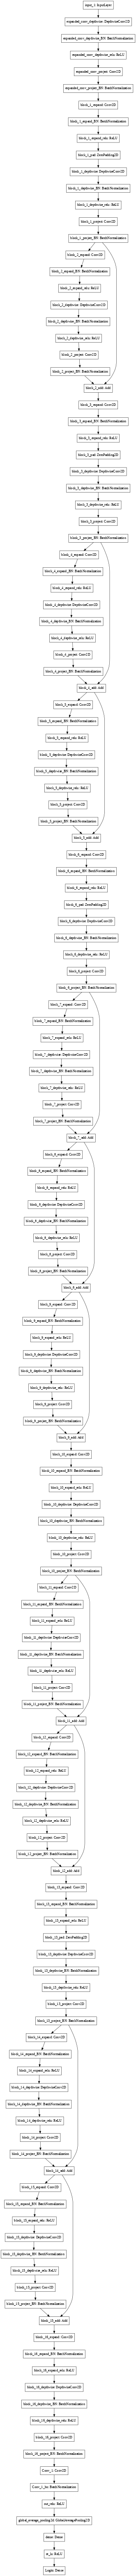

In [ ]:
tf.keras.utils.plot_model(model, dpi=40)

In [ ]:
# install tensorflow model optimization for quantization aware training

!pip install tensorflow_model_optimization

In [ ]:
# remove previously saved ckpts if there are any

!rm -rf /content/pose_ckpt/

In [ ]:
# TEST ON AFLW
# NOT BIWI
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_model_optimization as tfmot


# define callbacks and training metrics.
# early stop after not improving for 15 epochs
early = tf.keras.callbacks.EarlyStopping(
                                          monitor="val_loss",
                                          min_delta=0,
                                          patience=15,
                                          verbose=0,
                                          mode="auto",
                                          baseline=None,
                                          restore_best_weights=True,
                                          )
# batchsize and learning rate decay definition.
batch_size = 16
save_freq = 5
ckpt_freq = int((len(X_train) / batch_size) * 5)
start_decay_epoch = [30, 60]
decaylearningrate = DecayLearningRate(start_decay_epoch)

# optimizer selection
optMethod = Adam()
# model checkpoint callback
checkpoint_path = "/content/pose_ckpt/-{epoch:04d}.ckpt"
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=False,
                                                 save_weights_only=True, verbose=1,
                                                 save_freq=ckpt_freq)

# quantization aware training
quantize_model = tfmot.quantization.keras.quantize_model
# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)
# `quantize_model` requires a recompile.
model.compile(loss=['mae'], optimizer=optMethod, loss_weights=[1])
q_aware_model.summary()

# check the loss on the second dataset since its the harder and more important one.
callbacks = [decaylearningrate, early, cp_callback]
model.fit_generator(generator=data_generator_pose(X_train, Y_train, batch_size=batch_size),
                                    steps_per_epoch=X_train.shape[0] // batch_size,
                                    validation_data=(X_test_2, Y_test_2),
                                    epochs=300, verbose=1, callbacks=callbacks)
# hopenet default batchsize is 16

Model: "mobilenetv2_0.60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 64, 64, 3)    3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_expanded_conv_depthwise ( (None, 64, 64, 3)    30          quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_expanded_conv_depthwise_B (None, 64, 64, 3)    13          quant_expanded_conv_depthwise[0][
___________________________________________________________________________________

In [ ]:
# take a backup from the main trained model, so that the models from ckpts wont collide with it.
model_backup = model

In [ ]:
# copy checkpoints to drive
!cp -r /content/pose_ckpt/ /content/drive/MyDrive/

In [ ]:
model.save('/content/quant.h5')

In [ ]:
# convert to lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
with open('/content/quant.tflite', 'wb') as f:
  f.write(quantized_tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpsr6nav9o/assets


In [ ]:
# calculate benchmarking metrics on both datasets.

from sklearn.metrics import mean_absolute_error

def get_benchmark_results(model):
  pred_1 = model.predict(X_test_1)
  yaw, pitch, roll = Y_test_1[:, 0], Y_test_1[:, 1], Y_test_1[:, 2]
  pred_yaw, pred_pitch, pred_roll = pred_1[:, 0], pred_1[:, 1], pred_1[:, 2]

  yaw_mae = mean_absolute_error(yaw, pred_yaw)
  pitch_mae = mean_absolute_error(pitch, pred_pitch)
  roll_mae = mean_absolute_error(roll, pred_roll)

  print(f'BIWI')
  print(f'YAW: {yaw_mae}\nPITCH: {pitch_mae}\nROLL: {roll_mae}\n')
  print(f'MAE: {(yaw_mae+pitch_mae+roll_mae) / 3}')

  print('=========================')

  pred = model.predict(X_test_2)
  yaw, pitch, roll = Y_test_2[:, 0], Y_test_2[:, 1], Y_test_2[:, 2]
  pred_yaw, pred_pitch, pred_roll = pred[:, 0], pred[:, 1], pred[:, 2]

  yaw_mae = mean_absolute_error(yaw, pred_yaw)
  pitch_mae = mean_absolute_error(pitch, pred_pitch)
  roll_mae = mean_absolute_error(roll, pred_roll)

  print(f'AFLW')
  print(f'YAW: {yaw_mae}\nPITCH: {pitch_mae}\nROLL: {roll_mae}\n')
  print(f'MAE: {(yaw_mae+pitch_mae+roll_mae) / 3}')

get_benchmark_results(model)

BIWI
YAW: 3.8994671784529826
PITCH: 5.0540764522770205
ROLL: 2.6018295279063994

MAE: 3.851791052878801
AFLW
YAW: 4.005405548565678
PITCH: 5.656266054828211
ROLL: 4.023734673023688

MAE: 4.5618020921391915


In [ ]:
import tensorflow as tf

def load_model_from_ckpt(path):
  # 0061 is the last
  model = MobileNetV2(input_shape=(64, 64, 3), include_top=True, classes=3, alpha=0.6)
  latest = tf.train.latest_checkpoint(path, latest_filename='checkpoint')
  model.load_weights(latest)
  model.compile(loss=['mae'], optimizer=optMethod, loss_weights=[1])
  return model

temp = load_model_from_ckpt('/content/pose_ckpt/')
get_benchmark_results(temp)

BIWI
YAW: 3.8884045387677673
PITCH: 4.948589362227766
ROLL: 2.656535269831331

MAE: 3.8311763902756213
AFLW
YAW: 4.029069105922883
PITCH: 5.747231110398772
ROLL: 3.975032158809743

MAE: 4.583777458377132


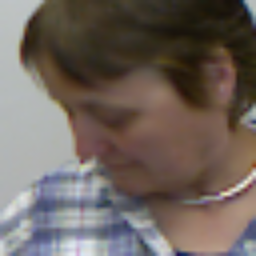

[[ 47. -45. -39.]]
[ 37.76773363 -51.35657112 -34.43247194]


In [ ]:
# visuallize some of the predictions on dataset images.

from google.colab.patches import cv2_imshow
import cv2

# YAW PITCH ROLL
i = 400
cv2_imshow(cv2.resize(X_test_1[i], (256, 256)))
sample = X_test_1[i]
sample = np.expand_dims(sample, axis=0)

print(np.around(model.predict(sample)))
print(Y_test_1[i])

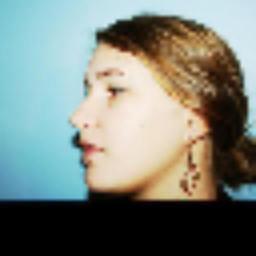

[[68. 12.  4.]]
[71.62278432 13.5477656   9.57131228]


In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# YAW PITCH ROLL
i = 10
cv2_imshow(cv2.resize(X_test_2[i], (256, 256)))
sample = X_test_2[i]
sample = np.expand_dims(sample, axis=0)

print(np.around(model.predict(sample)))
print(Y_test_2[i])